# 1D ME Exploration
- This notebook is intended to study the 1D Monitoring Elements at the LS level. 
- A requirements.txt is included to install the libraries used here.
- Note that in order to run the OMS API you will need to have a json file with the client ID (API_CLIENT_ID) and secret (API_CLIENT_SECRET). For more information on how to obtain these, you can take a look at these slides: https://indico.cern.ch/event/997758/contributions/4191705/attachments/2173881/3670409/OMS%20CERN%20OpenID%20migration%20-%20update.pdf


# Setup

In [1]:
#!pip install cmsdials --upgrade
#or
#!pip install cmsdials=1.1.0

In [2]:
#!pip show cmsdials

In [3]:
#DIALS API
from cmsdials import Dials
import cmsdials
from cmsdials.auth.bearer import Credentials
from cmsdials.filters import LumisectionHistogram1DFilters, FileIndexFilters, RunFilters, LumisectionHistogram2DFilters
creds = Credentials.from_creds_file()
dials = Dials(creds)

[2024-05-24 06:09:42,879] INFO: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-05-24 06:09:42,880] INFO: NumExpr defaulting to 8 threads.


In [4]:
# OMS API
import json
import os

with open("clientid.json", "r") as file:
    secrets = json.load(file)

os.environ["API_CLIENT_ID"] = secrets["API_CLIENT_ID"]
os.environ["API_CLIENT_SECRET"] = secrets["API_CLIENT_SECRET"]

import oms

oms_fetch = oms.oms_fetch()

In [5]:
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display
import utils
import plotly.express as px
import plotly.graph_objects as go
import math
from statistics import mean
from statistics import stdev
import plotly.io as pio

#%%matplotlib notebook

# Functions

In [6]:
def data_1d_me(run_number, me, regex):
    """
    Filters data by parameters below, sorts by ls_number, and converts it into numpy arrays
    
    Parameters:
    run_number, me, regex
    
    Returns:
    data, ls, x_min, x_max, x_bin, y_min, y_max
    """
    data = dials.h1d.list_all(
        LumisectionHistogram1DFilters(
            run_number=run_number,
            dataset__regex=regex,
            me=me,
        )
    )
    df = pd.DataFrame([x.__dict__ for x in data.results])
    sorted_df = df.sort_values(by='ls_number')
    
    ls = sorted_df['ls_number']
    histbins = sorted_df["data"].to_numpy(dtype=np.ndarray)
    histbins = np.array([np.array(x) for x in histbins])

    x_min = sorted_df["x_min"][0]
    x_max = sorted_df["x_max"][0]
    x_bin = sorted_df["x_bin"][0]
    y_min = histbins.min()
    y_max = histbins.max()
    
    return histbins, ls, x_min, x_max, x_bin, y_min, y_max


In [7]:
def calc_peak(histbins):
    """
    Find the maximum height of the histogram 
    """
    peak = max(np.max(np.histogram(hist)[1]) for hist in histbins)
    
    return peak

In [8]:
def plot_1d_me(histbins, histbins_ref, me_name, run_number, ref_run, write=False):
    """
    Plot the 1D ME , with a dropdown menu to switch between current and ref run
    
    Parameters:
    histbins: data array for current run
    histbins_ref: data array for ref run
    run_number: current run
    ref_run: reference run
    write: Boolean (choose to save the plot to an html file or not)
    
    Returns:
    plots figure
    writes it to an html file if write=True
    """
    
    max_peak = max(calc_peak(histbins), calc_peak(histbins_ref))

    # Create initial figure
    fig = go.Figure()

    # Add initial traces
    fig.add_trace(go.Bar(
        x=np.linspace(x_min, x_max, int(x_bin)),
        y=histbins[0],
        name='Current Run',
        visible=True
    ))

    fig.add_trace(go.Bar(
        x=np.linspace(x_min, x_max, int(x_bin)),
        y=histbins_ref[0],
        name='Reference Run',
        visible=False
    ))

    # Function to create slider steps
    def create_steps(data):
        steps = []
        for i in range(len(data)):
            step = dict(
                method="update",
                args=[{"y": [data[i]]}],
                label=str(i)
            )
            steps.append(step)
        return steps

    # Create sliders for both datasets
    slider_histbins = [dict(
        active=0,
        currentvalue={"prefix": "LS: "},
        pad={"t": 50},
        steps=create_steps(histbins)
    )]

    slider_histbins_ref = [dict(
        active=0,
        currentvalue={"prefix": "LS: "},
        pad={"t": 50},
        steps=create_steps(histbins_ref)
    )]


    y_axis_range = [0, max_peak]


    # Initial slider configuration
    fig.update_layout(
        sliders=slider_histbins,
        title=me_name,
        xaxis_title=me_name.split('/')[-1],
        yaxis_title='',
        yaxis_range=y_axis_range
    )

    # Add dropdown to switch between Current Run and Reference Run
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=list([
                    dict(
                        args=[{'visible': [True, False]}, {'sliders': slider_histbins}],
                        label="Current Run "+str(run_number),
                        method="update"
                    ),
                    dict(
                        args=[{'visible': [False, True]}, {'sliders': slider_histbins_ref}],
                        label="Reference Run "+str(ref_run),
                        method="update"
                    )
                ]),
                direction="down",
                showactive=True,
            ),
        ]
    )

    fig.show()
    
    if write:
        html_content = pio.to_html(fig, include_plotlyjs='cdn')

        # Write the HTML content to a file
        name_hist = str(run_number)+'_'+me_name.split('/')[-1]+'.html' 
        with open(name_hist, 'w') as f:
            f.write(html_content)

In [20]:
def plot_rate(hist, hist_ref, run_number, ref_run, x_axis, y_axis, title, write=False):
    
    plot = go.Figure()
    custom_ticks = [x+1 for x in range(len(hist))]

    plot.add_trace(go.Scatter(
        x = list(range(len(hist))),
        y = hist,
        visible=True
    ))

    plot.add_trace(go.Scatter(
        x = list(range(len(hist_ref))),
        y = hist_ref,
        visible=False
    ))

    # Add dropdown
    plot.update_layout(
        
        title=title,
        xaxis_title=x_axis,
        yaxis_title=y_axis,
        xaxis=dict(
            tickvals=list(range(len(hist))),
            ticktext=custom_ticks
        ),
        updatemenus=[
            dict(
                buttons=list([
                    dict(
                        args=[{'visible':[True, False]}],
                        label="Current Run "+ str(run_number),
                        method="restyle"
                    ),
                    dict(
                        args=[{'visible':[False, True]}],
                        label="Reference Run "+ str(ref_run),
                        method="restyle"
                    )
                ]),
                direction="down",
            ),
        ]
    )

    plot.show()
    
    if write:
        html_content = pio.to_html(plot, include_plotlyjs='cdn')

        # Write the HTML content to a file
        name_hist = str(run_number)+'_'+me_name.split('/')[-1]+'_'+title+'.html' 
        with open(name_hist, 'w') as f:
            f.write(html_content)
        #pio.write_html(fig, name_hist)

In [10]:
def get_oms_data(run_number):
    """
    Get trigger rate from OMS as a df and convert it to numpy array
    
    Parameters:
    run_number
    
    Returns:
    trigger_rate: ZeroBias trigger rate
    """
    extrafilter = dict(
        attribute_name="dataset_name",
        value="ZeroBias",
        operator="EQ",
    )

    attributes = [
        'start_time', 
        'last_lumisection_number', 
        'rate', 
        'run_number',
        'last_lumisection_in_run', 
        'first_lumisection_number', 
        'dataset_name',
        'cms_active', 
        'events'
    ]

    omstrigger_json = oms.get_oms_data(
        oms_fetch.omsapi, 
        'datasetrates', 
        run_number,
        extrafilters=[extrafilter],
        limit_entries = 2000
    )

    omstrigger_df = oms.oms_utils.makeDF(omstrigger_json)
    trigger_rate = np.array(omstrigger_df["rate"])

    return trigger_rate


In [87]:
def calc_trends(histbins, ls, max_value, trigger_rate, norm = False):
    """
    Calculates ~peak value, std error on mean, and list of empty LS.
    Also normalises by trigger rate if norm=True
    
    Parameters:
    histbins: data in the form of numpy array
    ls: list of lumisections
    max_value: maximum value of the quantity being measured along x-axis
    trigger_rate: np array obtained from oms
    norm: Boolean (default False)
    
    Returns:
    list_means: position of peak. It's not precise because the distributions are not Gaussian
    list_std: standard error on mean
    list_good_ls: non-zero LS
    empty_ls: 
    """
    list_means = [] #peak
    list_std= []
    list_good_ls = []
    empty_ls = []
    good_trigger = []
    for i in range(len(histbins)):
        ls_num = ls[i]
        # Calculate Mean and Std Error on Mean
        
        if any(histbins[i]):
            n_bins = len(histbins[i])
            actual_values = np.linspace(0, max_value, n_bins, endpoint=True) 
            
            peak_value = np.average(actual_values, weights=histbins[i]) #needs modification to get actual peak?? Fit a Landau/Langaus and get the MPV
            std_dev = stdev(histbins[i])
            sem = std_dev / np.sqrt(n_bins) # standard error on mean = (standard deviation)/sqrt(n)
            
            list_good_ls.append(ls_num)
            list_means.append(peak_value)
            list_std.append(sem) 
            good_trigger.append(trigger_rate[i])
        else:
            peak_value =0
            std_dev = 0
            empty_ls.append(ls_num)
        
    if norm:
        
        list_means = np.divide(list_means, good_trigger)
        list_std = np.divide(list_std, good_trigger) 
        

    return list_means, list_std, list_good_ls, empty_ls

In [40]:
def plot_trends(list_raw, list_norm, list_good_ls, title, me_name, runnb, write=False):

    plot = go.Figure()
    custom_ticks = [x for x in list_good_ls]
    plot.add_trace(go.Scatter(
        x = list(range(len(list_raw))),
        y = list_raw,
        visible=True
    ))

    plot.add_trace(go.Scatter(
        x = list(range(len(list_norm))),
        y = list_norm,
        visible=False
    ))


    # Add dropdown
    plot.update_layout(
        title=title+", "+me_name+", Run: "+str(runnb),
        xaxis_title='LS',
        xaxis=dict(
            tickvals=list(range(len(list_good_ls))),
            ticktext=custom_ticks
        ),
        updatemenus=[
            dict(
                buttons=list([
                    dict(
                        args=[{'visible':[True, False]}],
                        label="Raw",
                        method="restyle"
                    ),
                    dict(
                        args=[{'visible':[False, True]}],
                        label="Normalised",
                        method="restyle"
                    )
                ]),
                direction="down",
            ),
        ]
    )
    
    plot.show()
    
    if write:
        html_content = pio.to_html(plot, include_plotlyjs='cdn')

        # Write the HTML content to a file
        name_hist = str(run_number)+'_'+me_name.split('/')[-1]+'_'+title+'.html' 
        with open(name_hist, 'w') as f:
            f.write(html_content)
        #pio.write_html(fig, name_hist)

# Define ME name, Current Run and Ref Run

In [13]:
me_name = "PixelPhase1/Tracks/PXBarrel/charge_PXLayer_1"
run_number = 380238 
ref_run = 379765

regex = "ZeroBias"

In [14]:
data_current, ls, x_min, x_max, x_bin, y_min, y_max = data_1d_me(run_number, me_name, regex)

Progress: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s]


In [15]:
data_ref, ls_ref, x_min_ref, x_max_ref, x_bin_ref, y_min_ref, y_max_ref = data_1d_me(ref_run, me_name, regex)

Progress: 100%|██████████| 173/173 [00:26<00:00,  6.50it/s]


# Plot the distributions

In [79]:
plot_1d_me(data_current, data_ref, me_name, run_number, ref_run, write=True )

# Get Trigger Rate from OMS

In [16]:
trigger_rate = get_oms_data(run_number)
trigger_rate_ref = get_oms_data(ref_run)

https://vocms0185.cern.ch/agg/api/v1/datasetrates/?filter[run_number][EQ]=380238&filter[dataset_name][EQ]=ZeroBias&page[offset]=0&page[limit]=2000
https://vocms0185.cern.ch/agg/api/v1/datasetrates/?filter[run_number][EQ]=380238&filter[dataset_name][EQ]=ZeroBias&page[offset]=0&page[limit]=2000
https://vocms0185.cern.ch/agg/api/v1/datasetrates/?filter[run_number][EQ]=379765&filter[dataset_name][EQ]=ZeroBias&page[offset]=0&page[limit]=2000
https://vocms0185.cern.ch/agg/api/v1/datasetrates/?filter[run_number][EQ]=379765&filter[dataset_name][EQ]=ZeroBias&page[offset]=0&page[limit]=2000


In [21]:
title = 'TriggerRate'
y_axis ='Rate - Zero Bias'
x_axis = 'LS'
plot_rate(trigger_rate, trigger_rate_ref, run_number, ref_run, x_axis, y_axis, title, write=True)

# Calculate Mean, Std Error on Mean and empty LS list

In [88]:
max_value_charge = 80000 
list_means, list_std, list_good_ls, empty_ls = calc_trends(data_current, ls, max_value_charge, trigger_rate)
list_means_norm, list_std_norm, list_good_ls, empty_ls = calc_trends(data_current, ls, max_value_charge, trigger_rate, norm=True)

In [23]:
empty_ls

[37, 38, 39, 40]

In [89]:
title='MeanValue'

plot_trends(list_means, list_means_norm, list_good_ls, title, me_name, run_number, write=True)

In [42]:
title='Standard_Error_on_Mean'
plot_trends(list_std, list_std_norm, list_good_ls, title, me_name, run_number, write=True)

# Calculate Mean, Std Error on Mean and empty LS list for reference run

In [75]:

max_value_charge = 80000 
list_means_ref, list_std_ref, list_good_ls_ref, empty_ls_ref = calc_trends(data_ref, ls_ref, max_value_charge, trigger_rate_ref)
list_means_norm_ref, list_std_norm_ref, list_good_ls_ref, empty_ls_ref = calc_trends(data_ref, ls_ref, max_value_charge, trigger_rate_ref, norm=True)


/tmp/ipykernel_2558/4236685004.py:53: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_2558/4236685004.py:54: RuntimeWarning:

divide by zero encountered in divide



## Get indices with value inf 


In [66]:
inf_indices = [index for index, value in enumerate(list_means_norm_ref) if math.isinf(value)]
inf_indices

[320, 321, 1030, 1682]

## Non-zero charge values in data 


In [67]:
[list_means_ref[i] for i in inf_indices] 

[14543.841342531015,
 14573.620754428619,
 14682.723546281406,
 14461.028192371474]

In [47]:
#title='MeanValue'
#plot_trends(list_means_ref, list_means_norm_ref, list_good_ls_ref, title, me_name, ref_run, write=True)

In [51]:
#plt.plot(trigger_rate_ref)

In [48]:
#title='Standard_Error_on_Mean'
#plot_trends(list_std_ref, list_std_norm_ref, list_good_ls_ref, title, me_name, ref_run, write=True)

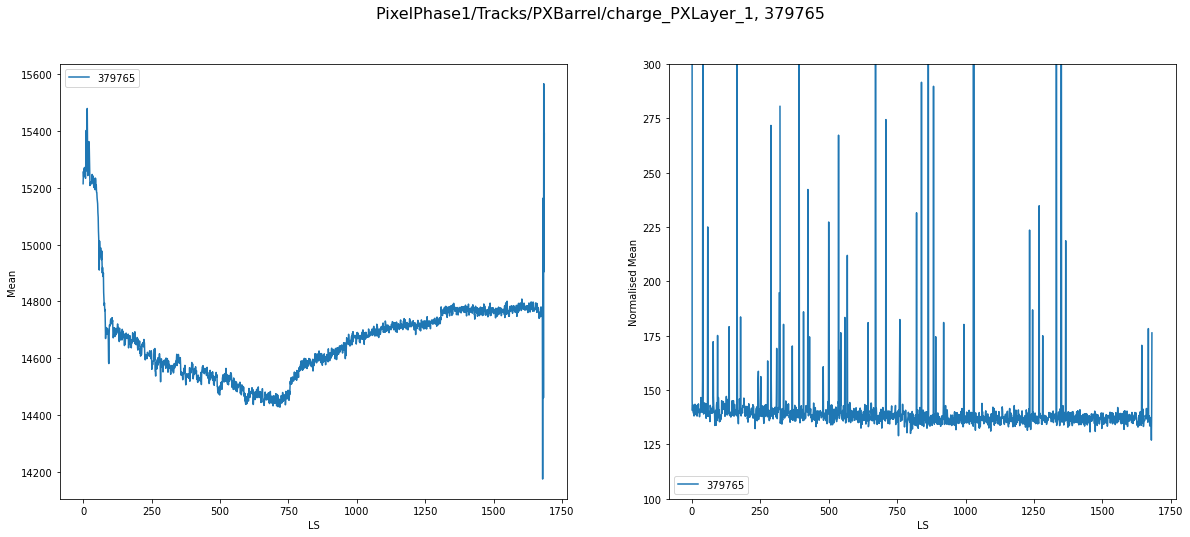

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.plot(list_means_ref, label=ref_run)
ax1.set_xlabel('LS')
ax1.set_ylabel('Mean')
ax1.legend()



ax2.plot(list_means_norm_ref, label=ref_run)
ax2.set_xlabel('LS')
ax2.set_ylabel('Normalised Mean')
ax2.set_ylim(100,300)

ax2.legend()


fig.suptitle("PixelPhase1/Tracks/PXBarrel/charge_PXLayer_1, "+str(ref_run), fontsize=16)
plt.show()


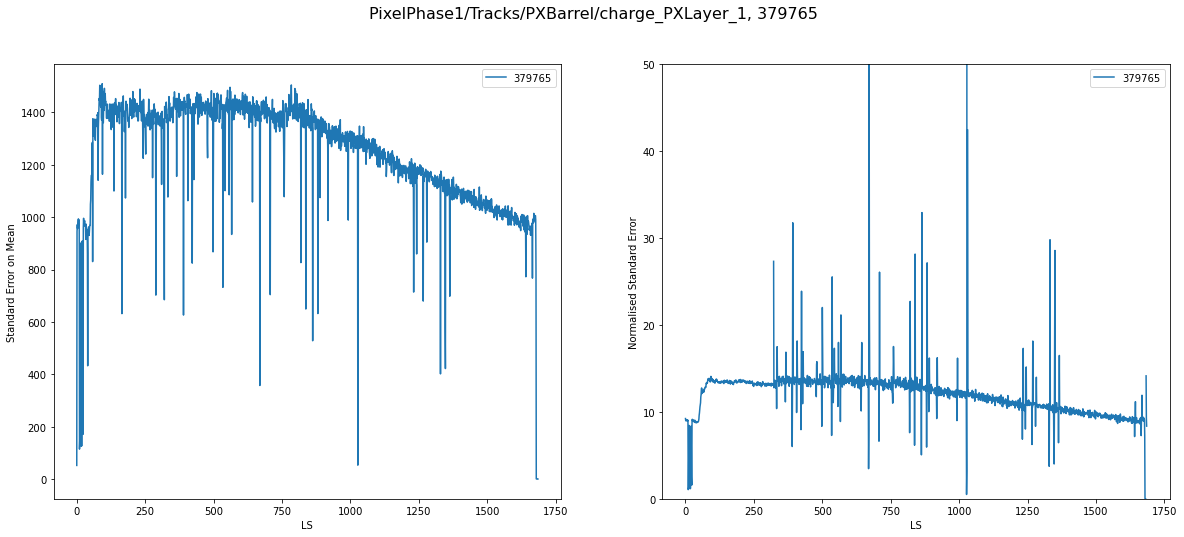

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.plot(list_std_ref, label=ref_run)
ax1.set_xlabel('LS')
ax1.set_ylabel('Standard Error on Mean')
ax1.legend()



ax2.plot(list_std_norm_ref, label=ref_run)
ax2.set_xlabel('LS')
ax2.set_ylabel('Normalised Standard Error')
ax2.set_ylim(0,50)

ax2.legend()


fig.suptitle("PixelPhase1/Tracks/PXBarrel/charge_PXLayer_1, "+str(ref_run), fontsize=16)
plt.show()


# Get a reference for mean pixel charge 
- Calculate mean of means for the reference run.
- Define a range outside which the mean and std dev would be marked as BAD: +/- 10%?

# Plot the trend plots with the reference ranges

## https://cmsoms.cern.ch/cms/triggers/l1_hlt_trigger_rates?cms_run=379765

- Physics off from 1 to 41.
- Tob, TibTid, TEC+, TEC-, BPix, FPix off until 41. Fpix off until 42
- Stable beam off until 40

- 380238 Filling Scheme	25ns_2352b_2340_2004_2133_108bpi_24inj
- 379765 Filling Scheme	25ns_1983b_1970_1657_1684_144bpi_19inj_3INDIVs 